<a href="https://colab.research.google.com/github/clmglbt/Additif-Model/blob/main/Mod%C3%A8le_Additif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from google.colab import files

#Sélectionnez le fichier vente_maillots_de_bain.csv

data_to_load = files.upload()

Saving vente_maillots_de_bain.csv to vente_maillots_de_bain.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['vente_maillots_de_bain.csv']))

sur le jeu de train : mean_train_absolute_error=28.42
sur le jeu de test : mean_test_absolute_error=39.80


<ipython-input-9-3a9f83fe8d6b>:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro:" (-> color='r'). The keyword argument will take precedence.
  plt.plot(self.data_preparation_object.dataset_df["index_mesure"][len(y_train_predicted):], self.data_preparation_object.y_test, "ro:", label="True Future Data", color="#FFFF99")


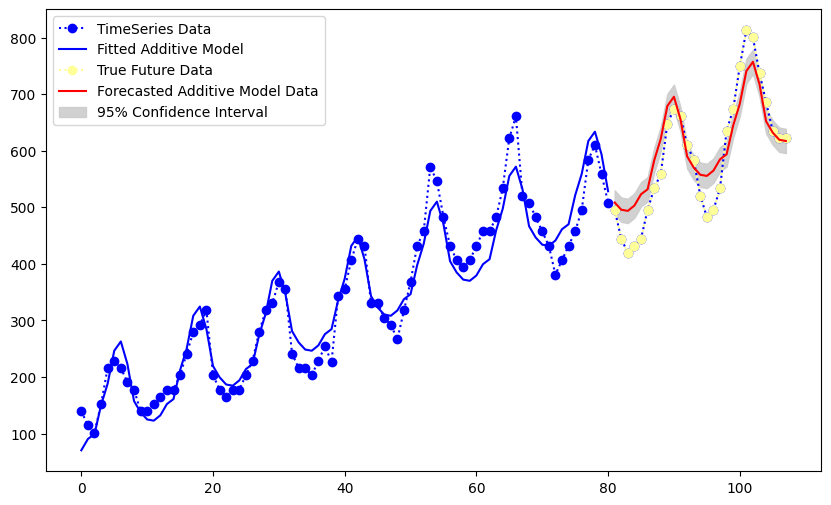

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

class DataPreparation:
    def __init__(self, csv_path):
        self.dataset_df = pd.read_csv(csv_path)
        self.dataset_df["Years"] = pd.to_datetime(self.dataset_df["Years"])
        self.prepare_data()

    def prepare_data(self):
        number_of_rows = len(self.dataset_df)
        self.dataset_df["index_mesure"] = np.arange(0, number_of_rows, 1)


        self.dataset_df["month_name"] = self.dataset_df["Years"].dt.month_name()

        month_dummies = pd.get_dummies(self.dataset_df["month_name"], prefix="month")

        self.dataset_df = pd.concat([self.dataset_df, month_dummies], axis=1)
        self.dataset_df.drop(["Years", "month_name"], axis=1, inplace=True)

        dataset_train_df = self.dataset_df.iloc[:int(number_of_rows * 0.75)]
        dataset_test_df = self.dataset_df.iloc[int(number_of_rows * 0.75):]

        self.x_train = dataset_train_df[[col for col in dataset_train_df.columns if col.startswith('month_')] + ['index_mesure']].values
        self.y_train = dataset_train_df[['Sales']].values

        self.x_test = dataset_test_df[[col for col in dataset_test_df.columns if col.startswith('month_')] + ['index_mesure']].values
        self.y_test = dataset_test_df[['Sales']].values


class Additif:

    def __init__(self, data_preparation_object):
        self.data_preparation_object = data_preparation_object
        self.model = LinearRegression()

        self.model.fit(data_preparation_object.x_train, data_preparation_object.y_train)

        y_train_predicted = self.model.predict(data_preparation_object.x_train)
        mean_train_absolute_error = np.mean(np.abs(y_train_predicted - data_preparation_object.y_train))
        print(f"sur le jeu de train : {mean_train_absolute_error=:.2f}")

        y_test_predicted = self.model.predict(data_preparation_object.x_test)
        mean_test_absolute_error = np.mean(np.abs(y_test_predicted - data_preparation_object.y_test))
        print(f"sur le jeu de test : {mean_test_absolute_error=:.2f}")

        self.show_model_predictions(y_train_predicted, y_test_predicted)

    def show_model_predictions(self, y_train_predicted, y_test_predicted):

        plt.figure(figsize=(10, 6))
        conf = 0.95

        residuals = self.data_preparation_object.y_test - y_test_predicted
        std_residuals = np.std(residuals)
        n = len(y_test_predicted)
        margin_error = 2.5 * (std_residuals / np.sqrt(n))

        minimum_interval = (y_test_predicted - margin_error).ravel()
        maximum_interval = (y_test_predicted + margin_error).ravel()

        plt.plot(self.data_preparation_object.dataset_df["index_mesure"], self.data_preparation_object.dataset_df["Sales"], "bo:", label="TimeSeries Data")

        plt.plot(self.data_preparation_object.dataset_df["index_mesure"][:len(y_train_predicted)], y_train_predicted, "b", label="Fitted Additive Model")

        plt.plot(self.data_preparation_object.dataset_df["index_mesure"][len(y_train_predicted):], self.data_preparation_object.y_test, "ro:", label="True Future Data", color="#FFFF99")

        plt.plot(self.data_preparation_object.dataset_df["index_mesure"][len(y_train_predicted):], y_test_predicted, "r", label="Forecasted Additive Model Data")

        plt.fill_between(self.data_preparation_object.dataset_df["index_mesure"][len(y_train_predicted):], minimum_interval, maximum_interval, color="#CCCCCC", alpha=0.9, label = "95% Confidence Interval")

        plt.legend()
        plt.show()

csv_path = "./vente_maillots_de_bain.csv"
data_preparation_object = DataPreparation(csv_path)
additif_object = Additif(data_preparation_object)
